## Import packages

In [ ]:
# If using Google Colab, uncomment the following line
# !pip install rasterio

import sys
print(sys.version)  # Print Python version in use

import numpy as np                                      # Array operations
import matplotlib.pyplot as plt                         # Plotting library
import torch                                            # Main PyTorch library
import os                                               # Operating system utilities
import glob                                             # File path management
import pandas as pd                                     # Data manipulation
import rasterio                                         # Geospatial raster data

from datetime import datetime, timedelta                # Date/time utilities

import deepSSF_model                                    # Import the .py file containing the deepSSF model                                          

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# output directory for saving plots
base_dir = f'outputs/landscape_predictions/S2'
os.makedirs(base_dir, exist_ok=True)
print(f"Base output directory: {base_dir}")

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]
Output directory: outputs/landscape_predictions/S2


### If using Google Colab, uncomment the following lines

The file directories will also need to be changed to match the location of the files in your Google Drive.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import the GPS data

We only use this for selecting a spatial extent for the area we want to predict over.

In [3]:
# select the id of that data that the model was trained on
buffalo_id = 2005
n_samples = 10297 # 2005 has 10297 samples

# Specify the path to your CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

         ta    cos_ta         x_min         x_max         y_min         y_max  \
0  1.367942  0.20

# Importing spatial data

Instead of importing the stacks of local layers (one for each step), here can import the spatial covariates at any extent, which we can predict the habitat selection over. We use an extent that covers all of the observed locations, which refer to as the 'landscape'.

## Sentinel-2 bands

Each stack represents a month of median values of cloud-free pixels, and each layer in the stack are the bands.

During the data preparation all of these layers were scaled by 10,000, and don't need to be scaled any further.

In [4]:
# Specify the directory containing your TIFF files
data_dir = '../mapping/cropped rasters/sentinel2/25m'  # Replace with the actual path to your TIFF files

# Use glob to get a list of all TIFF files matching the pattern
tif_files = glob.glob(os.path.join(data_dir, 'S2_SR_masked_scaled_25m_*.tif'))
print(f'Found {len(tif_files)} TIFF files')
print('\n'.join(tif_files))

Found 12 TIFF files
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_01.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_02.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_03.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_04.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_05.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_06.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_07.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_08.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_09.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_10.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_11.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_12.tif


In [5]:
# Initialise a dictionary to store data with date as the key
data_dict = {}

# Loop over each TIFF file to read and process the data
for tif_file in tif_files:
    # Extract the filename from the path
    filename = os.path.basename(tif_file)
    
    # Extract the date from the filename
    # Assuming filenames are in the format 'S2_SR_masked_YYYY_MM.tif'
    date_str = filename.replace('S2_SR_masked_scaled_25m_', '').replace('.tif', '')
    # date_str will be something like '2019_01'
    
    # Read the TIFF file using rasterio
    with rasterio.open(tif_file) as src:
        # Read all bands of the TIFF file
        data = src.read()
        # 'data' is a NumPy array with shape (bands, height, width)

        # Count the number of cells that are NaN
        n_nan = np.isnan(data).sum()

        print(f"Date: {date_str}")
        print(f"Number of NaN values in {date_str}: {n_nan}")
        print(f'Proportion of NaN values: {n_nan / data.size:.4%}\n')

        # Replace NaN values with zeros	
        data = np.nan_to_num(data, nan=0)
        
        # Add the data to the dictionary with date as the key
        data_dict[date_str] = data


Date: 2019_01
Number of NaN values in 2019_01: 2460
Proportion of NaN values: 0.0037%

Date: 2019_02
Number of NaN values in 2019_02: 420
Proportion of NaN values: 0.0006%

Date: 2019_03
Number of NaN values in 2019_03: 478731
Proportion of NaN values: 0.7291%

Date: 2019_04
Number of NaN values in 2019_04: 13296
Proportion of NaN values: 0.0202%

Date: 2019_05
Number of NaN values in 2019_05: 144
Proportion of NaN values: 0.0002%

Date: 2019_06
Number of NaN values in 2019_06: 144
Proportion of NaN values: 0.0002%

Date: 2019_07
Number of NaN values in 2019_07: 96
Proportion of NaN values: 0.0001%

Date: 2019_08
Number of NaN values in 2019_08: 144
Proportion of NaN values: 0.0002%

Date: 2019_09
Number of NaN values in 2019_09: 36
Proportion of NaN values: 0.0001%

Date: 2019_10
Number of NaN values in 2019_10: 0
Proportion of NaN values: 0.0000%

Date: 2019_11
Number of NaN values in 2019_11: 48
Proportion of NaN values: 0.0001%

Date: 2019_12
Number of NaN values in 2019_12: 0
Prop

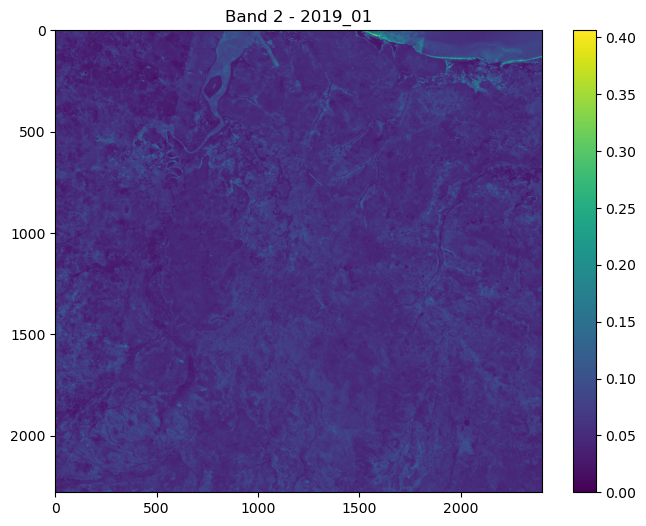

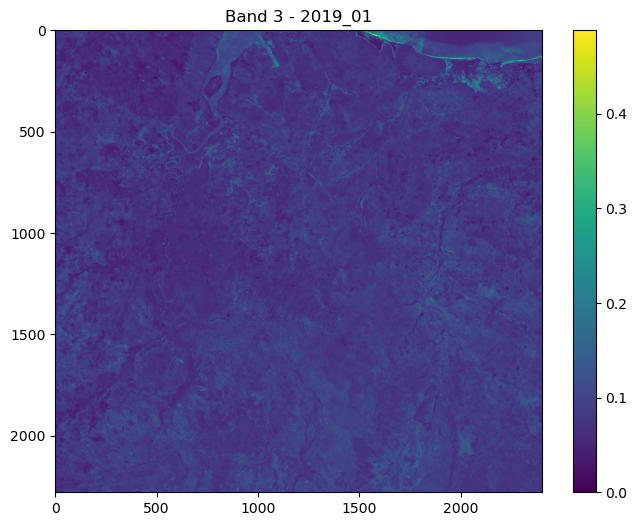

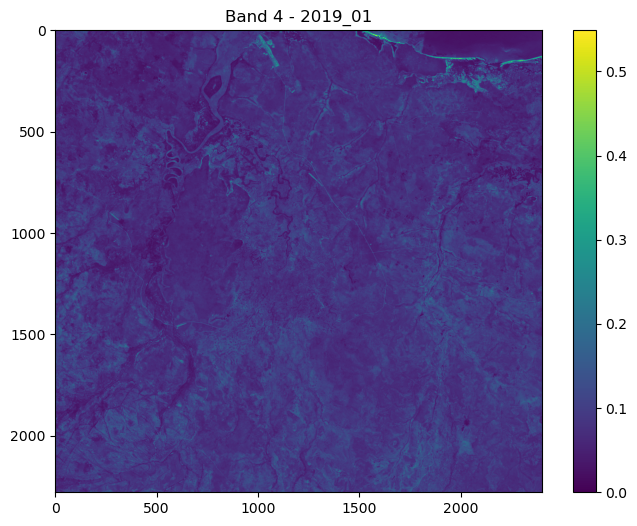

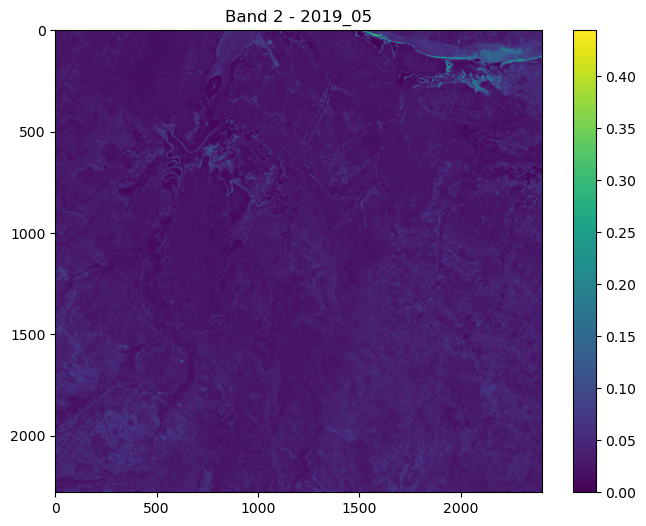

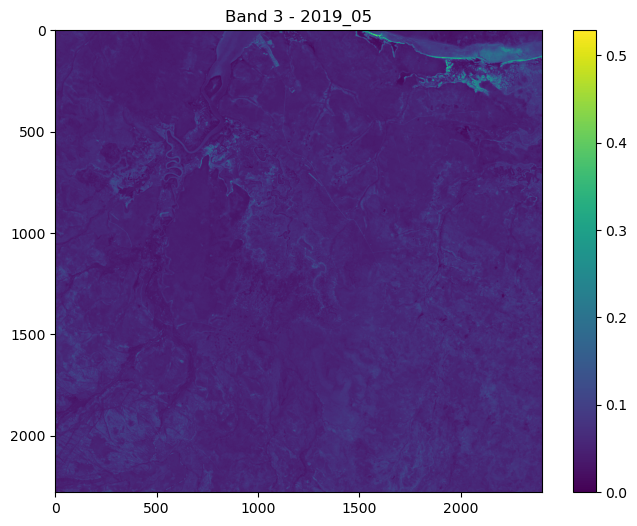

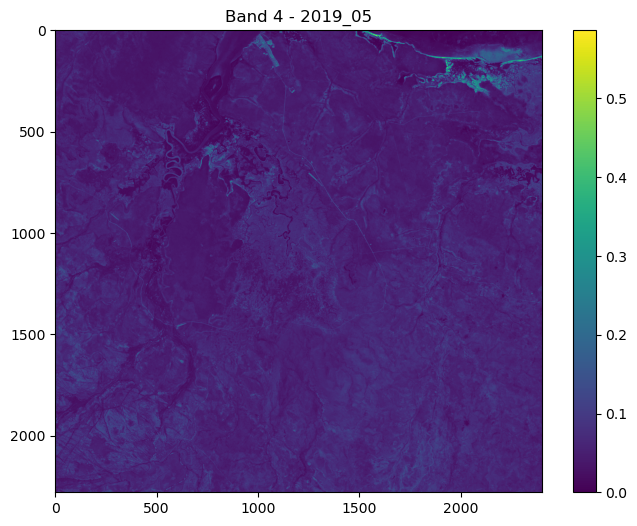

In [6]:
# Select some bands from the processed data stored in 'data_dict' for plotting
layers_to_plot = []

# Specify the date and band numbers you want to plot
dates_to_plot = ['2019_01', '2019_05']  # This grabs all available dates. You can select specific ones if needed.
bands_to_plot = [1, 2, 3]  # Band indices for bands 2, 3, and 4, which are B, G, and R

# Loop through the selected dates and bands to prepare them for plotting
for date_str in dates_to_plot:
    data = data_dict[date_str]  # Get the normalized data for this date
    
    for band_idx in bands_to_plot:
        # Collect the specific band for plotting
        layers_to_plot.append((data[band_idx], band_idx + 1, date_str))

# Plot the stored layers
for band, band_number, date_str in layers_to_plot:
    plt.figure(figsize=(8, 6))
    plt.imshow(band, cmap='viridis') 
    plt.title(f'Band {band_number} - {date_str}')
    plt.colorbar() #label='Normalized Value'
    plt.show()


### Plot as RGB

We can also visualise the Sentinel-2 bands as an RGB image, using the Red, Green and Blue bands.

The plotting was a bit dark so we will adjust the brightness of the image using a gamma correction.

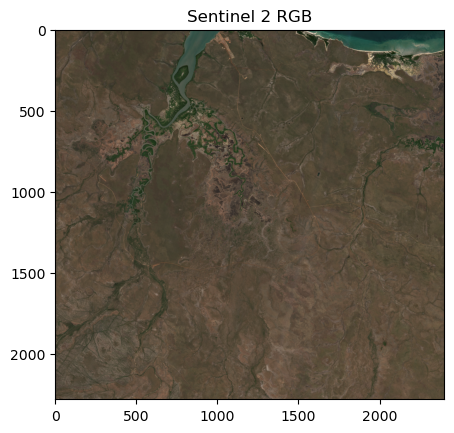

In [7]:
# Specify the date for the RGB layers
date_str = '2019_08'  

# pull out the RGB bands
r_band = data_dict[date_str][3]
g_band = data_dict[date_str][2]
b_band = data_dict[date_str][1]

# Stack the bands along a new axis
rgb_image = np.stack([r_band, g_band, b_band], axis=-1)
# Normalize to the range [0, 1] for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Apply gamma correction to the image
gamma = 1.75
rgb_image = rgb_image ** (1/gamma)

plt.figure()  # Create a new figure
plt.imshow(rgb_image)
plt.title('Sentinel 2 RGB')
plt.show()
plt.close()  # Close the figure to free memory

## Slope

In [89]:
# Path to the slope raster file
file_path = '../mapping/cropped rasters/slope.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    slope_landscape = src.read(1)
    # Get the metadata of the raster
    slope_meta = src.meta
    raster_transform = src.transform # same as the raster transform in the NDVI raster read

Slope metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Shape of slope landscape raster:
(2280, 2400)


Number of NA values in the slope raster:
9356


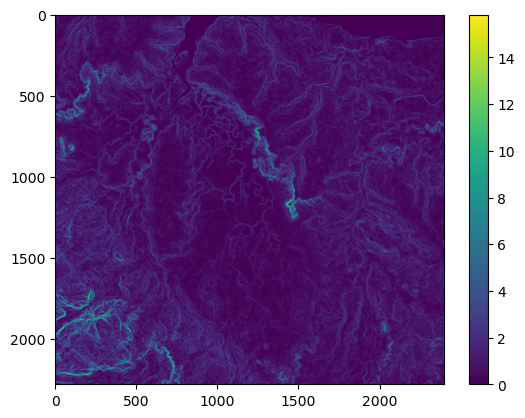

In [90]:
# Check the slope metadata:
print("Slope metadata:")
print(slope_meta)
print("\n")

# Check the shape (rows, columns) of the slope landscape raster:
print("Shape of slope landscape raster:")
print(slope_landscape.shape)
print("\n")

# Check for NA values in the slope raster:
print("Number of NA values in the slope raster:")
print(np.isnan(slope_landscape).sum())

# Replace NaNs in the slope array with 0.0 (representing water):
slope_landscape = np.nan_to_num(slope_landscape, nan=0.0)

# Define the maximum and minimum slope values from the stack of local layers:
slope_max = 12.2981
slope_min = 0.0006

# Convert the slope landscape data from a NumPy array to a PyTorch tensor:
slope_landscape_tens = torch.from_numpy(slope_landscape)

# Normalize the slope landscape data:
slope_landscape_norm = (slope_landscape_tens - slope_min) / (slope_max - slope_min)

# Visualize the slope landscape (note: displaying the original tensor, not the normalised data):
plt.imshow(slope_landscape_tens.numpy())
plt.colorbar()
plt.show()


# Prepare data for running the model

## Select a smaller extent of the landscape

To illustrate the approach, we will select a smaller extent of the landscape to predict over, which covers the spatial extent of the training data. 

In [91]:
# from the buffalo data
buffer = 1250
min_x = min(buffalo_df['x_']) - buffer
max_x = max(buffalo_df['x_']) + buffer
min_y = min(buffalo_df['y_']) - buffer
max_y = max(buffalo_df['y_']) + buffer

# custom extent in epsg:3112
# min_x = 28148.969145
# max_x = 47719.496935
# min_y = -1442210.335861
# max_y = -1433133.681746

# Convert geographic coordinates to pixel coordinates
min_px, min_py = ~raster_transform * (min_x, min_y)
print(min_px, min_py)
max_px, max_py = ~raster_transform * (max_x, max_y)
print(max_px, max_py)

# Round pixel coordinates to integers
min_px, max_px, min_py, max_py = int(round(min_px)), \
    int(round(max_px)), \
        int(round(min_py)), \
            int(round(max_py))

# Print the pixel coordinates	
print(f"Min x = {min_px}, Max x = {max_px}, \nMin y = {min_py}, Max y = {max_py}")

1091.3389860694217 1546.6350942641802
2166.104503472696 888.6517715825685
Min x = 1091, Max x = 2166, 
Min y = 1547, Max y = 889


### Select a monthly stack of Sentinel 2 bands

We will select a monthly stack of Sentinel 2 bands to predict the habitat selection over. First use a function that will select the correct stack of bands for a given month.

This indexing is slightly different from the indexing we used for the `deepSSF_landscape_preds.ipynb` and `deepSSF_simulations.ipynb` notebooks, which was indexing NDVI layers. In that case we were indexing the layers directly, and therefore the first entry was at 0 (i.e., March was in month_index = 2). Here, we are creating a string that corresponds to the layer name, and therefore the first entry is at 1. (i.e., March will be at month_index = 3)

In [92]:
# Create a mapping from day of the year to month index
def day_to_month_index(day_of_year):
    # Calculate the year and the day within that year
    base_date = datetime(2019, 1, 1)
    date = base_date + timedelta(days=int(day_of_year) - 1)
    year_diff = date.year - base_date.year
    month_index = (date.month) + (year_diff * 12)  # month index (1-based)
    if month_index == 0:
        month_index += 1
    return month_index

Choose a day of the year and get the month to index by.

In [93]:
# Choose a day of the year
yday_t2 = 50
# Get the month index for the selected day
month_index = day_to_month_index(yday_t2) 
print(f'Month index:    {month_index}')

# For sentinel 2 data
selected_month = f'2019_{month_index:02d}'
print(f'Selected month: {selected_month}')

# Get the data for the selected month
sentinel_layers = data_dict[selected_month]
print(sentinel_layers.shape)

Month index:    2
Selected month: 2019_02
(12, 2280, 2400)


# Subset all layers

### Create directory for saving plots

In [94]:
# Output directory for saving plots
base_id_dir = f'{base_dir}/id{buffalo_id}'
os.makedirs(base_id_dir, exist_ok=True)
print(f"Output directory: {base_id_dir}")

Output directory: outputs/landscape_predictions/S2/id2005


Here we want to crop the layers to the spatial extent defined above. 

For plotting purposes, we convert the normalised landscape layers back to their natural scale. This is only for plotting and are not used for modelling. 

We also calculate the minimum and maximum values of the normalised landscape subsets, which we will use to define the colour scale when plotting the layers.

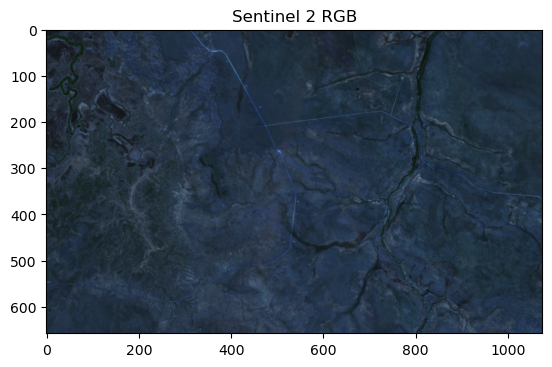

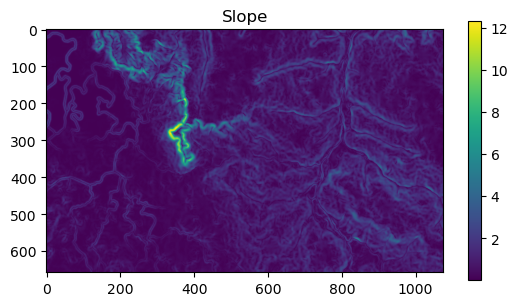

In [116]:
# Initialize a subset array with zeros (or another padding value) 
# with the dimensions defined by the pixel indices.
subset = np.zeros((min_py - max_py, max_px - min_px), dtype=slope_landscape.dtype)

# Initialize a list to store the results
layer_subsets = []

# Loop over each layer in sentinel_layers and global_raster_tensors
for sentinel_layer in sentinel_layers:
    # Process the sentinel layer
    sentinel_layer = torch.from_numpy(sentinel_layer)
    # print(sentinel_layer.shape)
    sentinel_result = sentinel_layer[max_py:min_py, min_px:max_px]
    layer_subsets.append(sentinel_result)

# Add the normalised slope layer to the list of layer subsets
slope_subset = slope_landscape_norm[max_py:min_py, min_px:max_px]
# Convert the slope subset back to the natural scale (for plotting only)
slope_subset_natural = slope_subset * (slope_max - slope_min) + slope_min

# Append the slope subset to the list of layer subsets
layer_subsets.append(slope_subset)


# Pull out the Sentinel-2 RGB bands for plotting
r_band = layer_subsets[1].detach().numpy()
g_band = layer_subsets[2].detach().numpy()
b_band = layer_subsets[3].detach().numpy()

# Stack the bands along a new axis
rgb_image = np.stack([r_band, g_band, b_band], axis=-1)
# Normalize to the range [0, 1] for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# # Apply gamma correction to brighten the image
gamma = 1.1
rgb_image = rgb_image ** (1/gamma)

# Plot and save the RGB image
plt.imshow(rgb_image)
plt.title('Sentinel 2 RGB')
plt.savefig(f"{base_id_dir}/id{buffalo_id}_rgb_yday{yday}.png", dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

# plot the subset
plt.imshow(slope_subset_natural, cmap='viridis')
plt.colorbar(shrink=0.7)
plt.title(f'Slope')
plt.savefig(f"{base_id_dir}/id{buffalo_id}_slope.png", dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory


# Load the model

### Set the device for the model

In [61]:
# run on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


## Define the parameters for the model

Here we enter the specific parameter values and hyperparameters for the model. 
These are the values that will be used to instantiate the model.

In [31]:
# In our case the 12 Sentinel-2 layers + slope
num_spatial_covs = 13 

params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": num_spatial_covs + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

As described in the `deepSSF_train.ipynb` script, we saved the model definition into a file named `deepSSF_model.py`. We can instantiate the model by importing the file (which was done when importing other packages) and calling the classes parameter dictionary from that script.

In [32]:
params = deepSSF_model.ModelParams(params_dict)
model = deepSSF_model.ConvJointModel(params).to(device)
print(model)

ConvJointModel(
  (scalar_grid_output): Scalar_to_Grid_Block()
  (conv_habitat): Conv2d_block_spatial(
    (conv2d): Sequential(
      (0): Conv2d(17, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_movement): Conv2d_block_toFC(
    (conv2d): Sequential(
      (0): Conv2d(17, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fcn_movement_all): FCN_block_all_movement(
    (ffn): Sequential(
      (0): Linear(in_features=2500, out_features=128,

In [33]:
# # load the model weights
# print(model.state_dict())
model.load_state_dict(torch.load(f'model_checkpoints/deepSSF_S2_slope_buffalo2005_2025-02-09.pt', 
                                 map_location=torch.device('cpu'),
                                 weights_only=True))
# print(model.state_dict())
# model.eval()

<All keys matched successfully>

# Run habitat selection subnetwork on landscape layers

Add the slope subset layer to the device.

In [96]:
slope_subset = slope_subset.to(params.device)

## Prepare the scalar covariates

We need the hour of the day and day of the year to predict with (as the model was trained with these as inputs). 

In this example we'll select a single hour and a single day of the year to predict over, and then below we'll loop over the hours of the day to illustrate the temporal variation in habitat selection that was learned by the model.

In [98]:
# Hour of the day (hour) 
hour_t2 = 17
# Convert to sine and cosine (as this is what the model expects)
hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
hour_t2_cos = np.cos(2*np.pi*hour_t2/24)

# Day of the year (yday)
print(f"Day of the year: {yday}") # yday was defined earlier
# Convert to sine and cosine
yday_t2_sin = np.sin(2*np.pi*yday_t2/365)
yday_t2_cos = np.cos(2*np.pi*yday_t2/365)

# Convert the numpy scalars to PyTorch tensors and ensure they are float type.
# unsqueeze(0) adds a batch dimension.
hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float().unsqueeze(0)
hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float().unsqueeze(0)
yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float().unsqueeze(0)
yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float().unsqueeze(0)

def scalar_to_grid(x, dim_x, dim_y):
    """
    Reshape a scalar tensor to a grid with the given dimensions.
    
    Args:
        x (torch.Tensor): Input scalar tensor of shape [1].
        dim_x (int): Number of rows for the grid.
        dim_y (int): Number of columns for the grid.
        
    Returns:
        torch.Tensor: Tensor expanded to shape [1, 1, dim_x, dim_y].
    """
    # View x as shape [1, 1, 1, 1] and expand to a grid of shape [1, 1, dim_x, dim_y]
    scalar_map = x.view(1, 1, 1, 1).expand(1, 1, dim_x, dim_y)
    return scalar_map

# Stack the scalar tensors along a new dimension (dim=0) to form a tensor with shape [4, 1]
# representing the four covariates: hour sin, hour cos, day-of-year sin, day-of-year cos.
scalar_covariates = torch.stack([
    hour_t2_sin_tensor, 
    hour_t2_cos_tensor, 
    yday_t2_sin_tensor, 
    yday_t2_cos_tensor
], dim=0)
print(scalar_covariates.shape)  # Expected shape: [4, 1]

# Convert each scalar covariate into a grid matching the dimensions of the NDVI landscape.
# This creates spatial maps where each grid cell contains the same scalar value.
scalar_grids = torch.cat([
    scalar_to_grid(tensor, slope_subset.shape[0], slope_subset.shape[1]) 
    for tensor in scalar_covariates
], dim=1)
print(scalar_grids.shape)  # Expected shape: [1, 4, rows, cols]

Day of the year: 50
torch.Size([4, 1])
torch.Size([1, 4, 658, 1075])


## Combine the spatial and scalar (as grid) covariates

In [99]:
# Stack the individual landscape layers into a single tensor.
# The resulting tensor has shape [13, rows, cols].
landscape_stack = torch.stack(layer_subsets, dim=0)

# Add an extra batch dimension to the tensor.
# Now the shape becomes [1, 4, rows, cols], where 1 indicates a single sample.
landscape_stack = landscape_stack.unsqueeze(0)
print(landscape_stack.shape)

# Concatenate the landscape stack with the scalar grids along the channel dimension.
# This merges the spatial features (landscape_stack) and the repeated scalar covariate grids (scalar_grids)
# into a full feature tensor with shape [1, total_channels, rows, cols].
full_stack = torch.cat([landscape_stack, scalar_grids], dim=1)
print(full_stack.shape)

torch.Size([1, 13, 658, 1075])
torch.Size([1, 17, 658, 1075])


## Run habitat selection subnetwork on the landscape layers

All we need to do to run the habitat selection subnetwork of the model is to pull that component out of the model and run it on the landscape layers.

In [100]:
# Pass the full feature stack through the habitat convolutional layer of the model to get predictions.
landscape_predictions = model.conv_habitat(full_stack)

# Print the shape of the output tensor to verify the dimensions of the predictions.
print(landscape_predictions.shape)

torch.Size([1, 658, 1075])


## Plot the predictions

Create a directory with a folder for the day of the year.

In [102]:
# To save the images, create a directory
base_id_day_dir = f'{base_id_dir}/yday{yday_t2}'
os.makedirs(base_id_day_dir, exist_ok=True)
print(f"Output directory: {base_id_day_dir}")

Output directory: outputs/landscape_predictions/S2/id2005/yday50


As the spatial inputs are padded by the model, there are artifacts at the edges of the predictions. Sometimes this can result in quite different values to the rest of the predictions, which changes the colour scale. To prevent this we remove the outer pixels of the predictions.

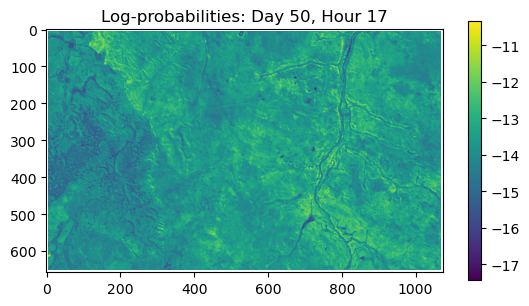

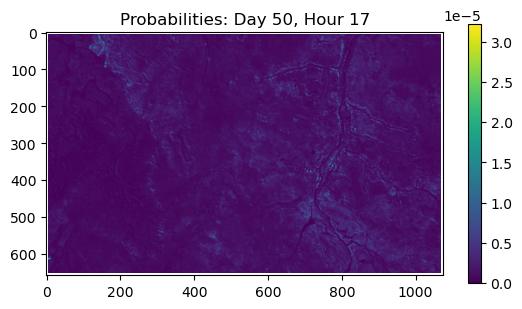

In [103]:
# Extract the first sample from the output tensor, detach it from the computational graph,
# move it to the CPU, and convert it to a NumPy array for further processing and visualization.
output_image = landscape_predictions[0].detach().cpu().numpy()

# Create masks for the x and y coordinates, as well as a water mask (unused in the code below),
# with the same shape as the output image.
x_mask = np.ones_like(output_image)
y_mask = np.ones_like(output_image)
water_mask = np.ones_like(output_image)

# Get the dimensions of the output image.
y_dim = output_image.shape[0]
x_dim = output_image.shape[1]

# Define a buffer value to mask out edge cells.
buffer = 3

# Apply the buffer mask to the x-axis: set the first and last 'buffer' columns to -infinity.
x_mask[:, :buffer] = -np.inf
x_mask[:, x_dim - buffer:] = -np.inf

# Apply the buffer mask to the y-axis: set the first and last 'buffer' rows to -infinity.
y_mask[:buffer, :] = -np.inf
y_mask[y_dim - buffer:, :] = -np.inf

# Mask out edge cells in the output image by multiplying with the x and y masks.
# Also mask out water cells by multiplying with the water mask.
output_image = output_image * x_mask * y_mask
output_image = output_image * water_mask

# Plot the masked output image using the 'viridis' colormap.
plt.imshow(output_image, cmap='viridis')
plt.colorbar(shrink=0.7)  # Display the color scale.
plt.title(f'Log-probabilities: Day {yday_t2}, Hour {hour_t2}')
# Define the filename for saving the landscape prediction image
plt.savefig(f"{base_id_day_dir}/id{buffalo_id}_hab_log_prob_yday{yday_t2}_hour{hour_t2}.png", 
            dpi=600, bbox_inches='tight') 
plt.show()
plt.close()  # Close the figure to free up memory.

# Plot the exponential of the output image, which may be used to convert log-probabilities
# back to probability values.
plt.imshow(np.exp(output_image), cmap='viridis')
plt.colorbar(shrink=0.7)  # Display the color scale.
plt.title(f'Probabilities: Day {yday_t2}, Hour {hour_t2}')
# Define the filename for saving the landscape prediction image
plt.savefig(f"{base_id_day_dir}/id{buffalo_id}_hab_prob_yday{yday_t2}_hour{hour_t2}.png", 
            dpi=600, bbox_inches='tight') 
plt.show()
plt.close()  # Close the figure to free up memory.

## Loop over hours

A benefit of the `deepSSF` approach is that it can represent temporal variation in habitat selection (and movement dynamics) across the day, which interacts with the day of the year. 

To illustrate this, we can loop over the hours of the day and predict the habitat selection at each hour. We can also assess the contribution of each covariate to the predictions at each hour, giving us some idea of what the model has learned about the temporal variation in habitat selection, which can help us to further understand our species' spatial ecology.

In [104]:
# To plot the prediction maps with the same colour scale, 
# we need to determine the minimum and maximum values
# Initialize landscape min and max values
landscape_vmin = float('inf')
landscape_vmax = float('-inf')

### Select the day of the year

We will select a single day of the year to predict over, and then loop over the hours of the day.

In [135]:
# Choose a day of the year
yday_t2 = 250
# Get the month index for the selected day
month_index = day_to_month_index(yday_t2) 
print(f'Month index:    {month_index}')

# For sentinel 2 data
selected_month = f'2019_{month_index:02d}'
print(f'Selected month: {selected_month}')

# Get the data for the selected month
sentinel_layers = data_dict[selected_month]
print(sentinel_layers.shape)

# Convert day of the year to sine and cosine
yday_t2_sin = np.sin(2*np.pi*yday_t2/365)
yday_t2_cos = np.cos(2*np.pi*yday_t2/365)

Month index:    9
Selected month: 2019_09
(12, 2280, 2400)


## Crop the Sentinel-2 bands

In [136]:
# Initialize a subset array with zeros (or another padding value) 
# with the dimensions defined by the pixel indices.
subset = np.zeros((min_py - max_py, max_px - min_px), dtype=slope_landscape.dtype)

# Initialize a list to store the results
layer_subsets = []

# Loop over each layer in sentinel_layers and global_raster_tensors
for sentinel_layer in sentinel_layers:
    # Process the sentinel layer
    sentinel_layer = torch.from_numpy(sentinel_layer)
    # print(sentinel_layer.shape)
    sentinel_result = sentinel_layer[max_py:min_py, min_px:max_px]
    layer_subsets.append(sentinel_result)

# Append the slope subset to the list of layer subsets
layer_subsets.append(slope_subset)

# Stack the spatial layers along a new dimension (dim=0)
landscape_stack = torch.stack(layer_subsets, dim=0)
landscape_stack = landscape_stack.unsqueeze(0) # add a batch dimension
print(landscape_stack.shape) # Expected shape: [1, 13, rows, cols]

torch.Size([1, 13, 658, 1075])


Update the directory with the correct day of the year.

In [137]:
# To save the images, create a directory
base_id_day_dir = f'{base_id_dir}/yday{yday_t2}'
os.makedirs(base_id_day_dir, exist_ok=True)
print(f"Output directory: {base_id_day_dir}")

Output directory: outputs/landscape_predictions/S2/id2005/yday250


As we need to run over the full loop to get the `landscape_vmin` and `landscape_vmax` values, we will first run the loop over the hours of the day once without plotting (which is much faster), and then in the following code chunk run over the loop again but plot the predictions and save the images.

This loop generates the predictions and saves the probability values as a csv to correlate with covariate values (which we do in R).

In [138]:
# Define the range of hours you want to loop over
hours = range(1,25) # to start at 1

# As we used sine and cosine terms to represent the hour of the day,
# rather than the hour as integers, we can use a continuous range of hours
# (Uncomment line below)
# hours = np.arange(0,24, 0.1)

for hour_t2 in hours:

    # convert hour to sine and cosine
    hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
    hour_t2_cos = np.cos(2*np.pi*hour_t2/24)

    # Convert numpy objects to PyTorch tensors
    hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float().unsqueeze(0)
    hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float().unsqueeze(0)
    yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float().unsqueeze(0)
    yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float().unsqueeze(0)

    # Stack tensors column-wise to create a tensor of shape 
    scalar_covariates = torch.stack([hour_t2_sin_tensor, 
                                     hour_t2_cos_tensor, 
                                     yday_t2_sin_tensor, 
                                     yday_t2_cos_tensor], 
                                     dim=0)
    
    # Convert each scalar covariate into a grid matching the dimensions of the NDVI landscape
    scalar_grids = torch.cat([scalar_to_grid(tensor, 
                                             slope_subset.shape[0], 
                                             slope_subset.shape[1]) 
                                             for tensor in scalar_covariates
                                             ], dim=1)

    # Stack the spatial (landscape_stack) and scalar covariates (as grids)
    full_stack = torch.cat([landscape_stack, scalar_grids], dim=1)
    # print(full_stack.shape) # Expected shape: [1, n_channels, rows, cols]

    # Run the model
    landscape_predictions = model.conv_habitat(full_stack)
    # print(landscape_predictions.shape)

    # Pull out the prediction
    output_image = landscape_predictions[0].detach().cpu().numpy()

    # Mask out cells on the edges (that affect the colour scale)
    output_image = output_image * x_mask * y_mask

    # Check if output_image is valid before updating landscape min and max
    if output_image.size > 0:
        # Ignore masked values in the calculation
        valid_values = output_image[np.isfinite(output_image)]
        if valid_values.size > 0:
            current_min = valid_values.min()
            current_max = valid_values.max()

            # Update landscape min and max values for scaling the colour map
            landscape_vmin = min(landscape_vmin, current_min)
            landscape_vmax = max(landscape_vmax, current_max)

print(landscape_vmin, landscape_vmax)

-18.706799 -8.748095


In this chunk we generate the plots (now the `landscape_vmin` and `landscape_vmax` values are set) and save them to the output directory.

We can save both the log-probabilities and the probabilities in their natural scale. We've saved the images of the log-probabilities, but just uncomment the appropriate lines to save the images of the probabilities as well.

Here are some examples:

**Day 125 - May 5th - early dry season**

![](../figures/S2_landscape_preds_yday125.gif)


**Day 250 - September 7th - dry season**

![](../figures/S2_landscape_preds_yday250.gif)

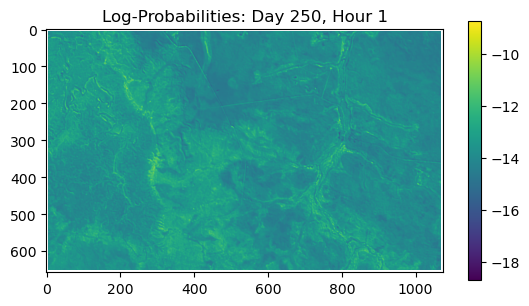

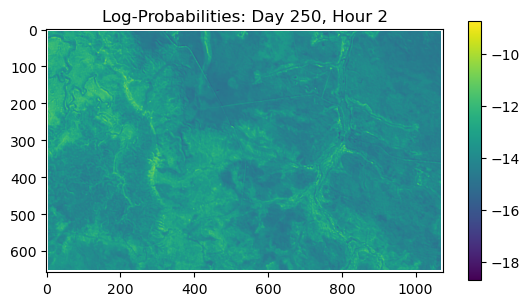

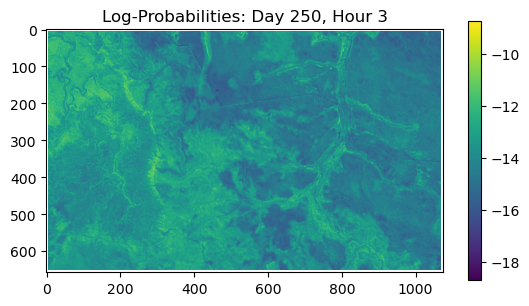

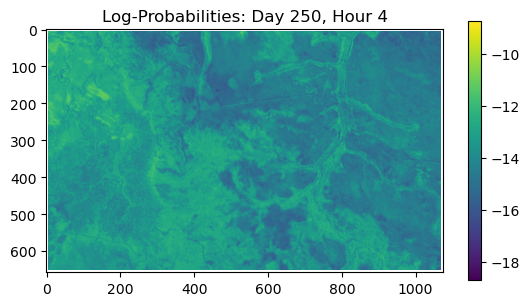

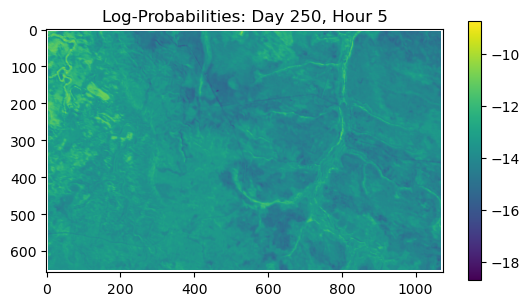

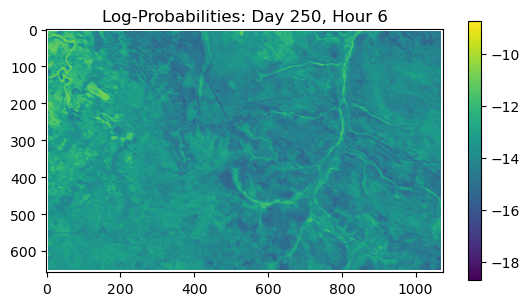

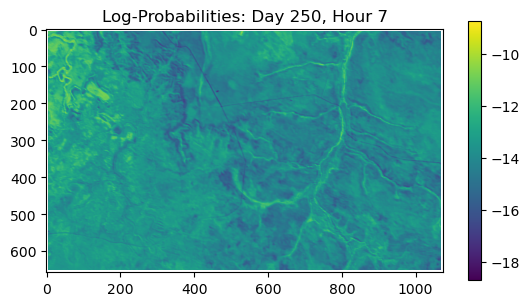

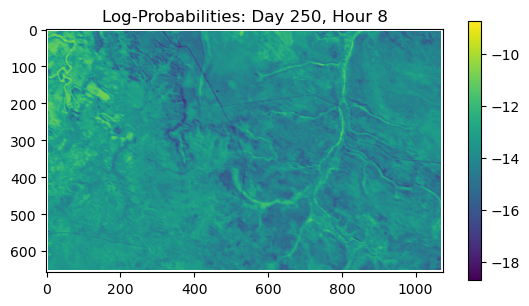

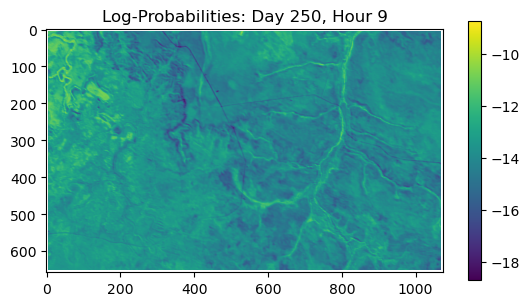

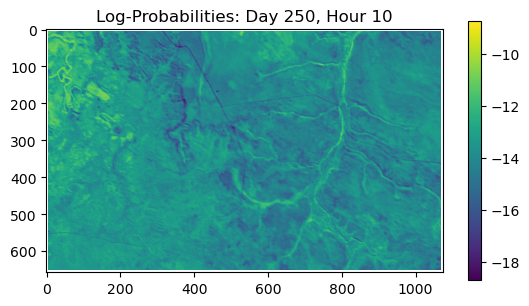

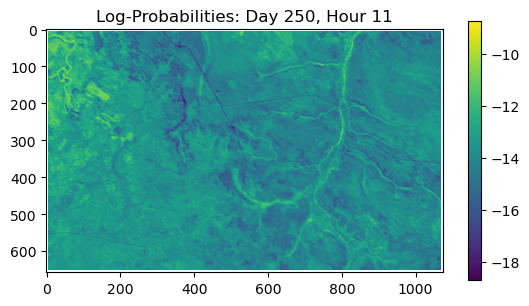

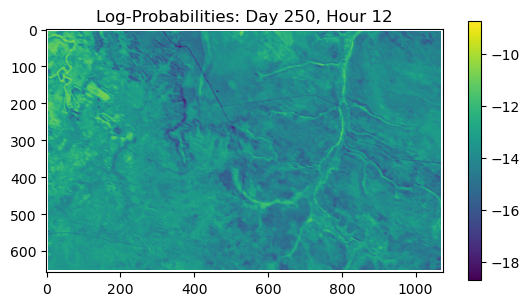

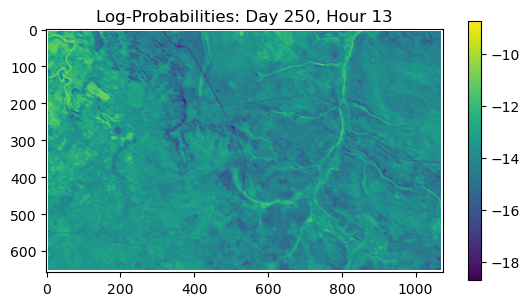

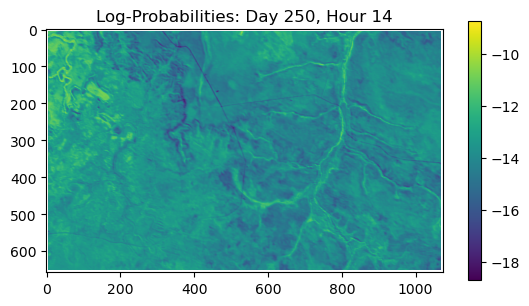

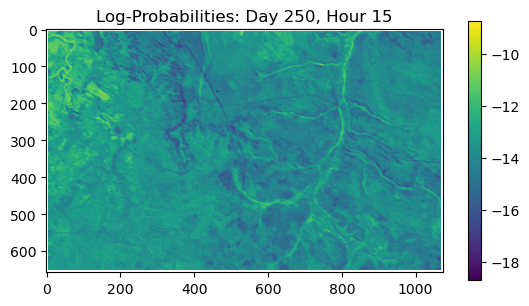

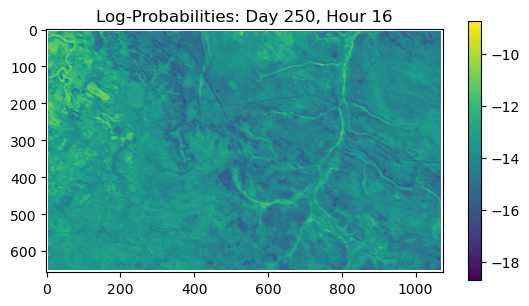

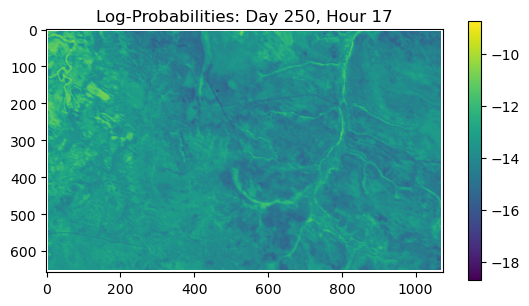

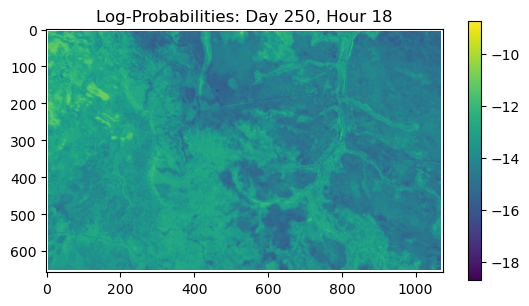

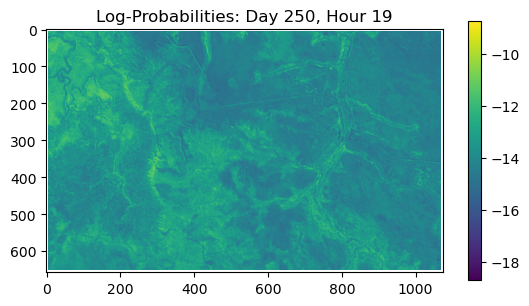

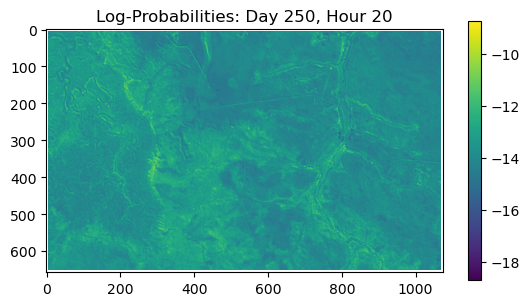

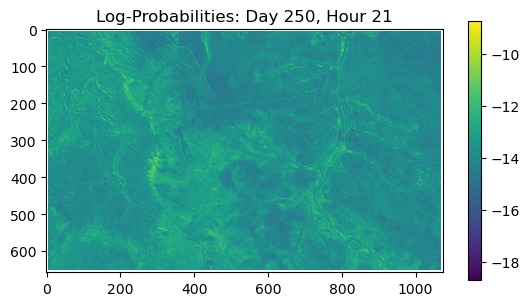

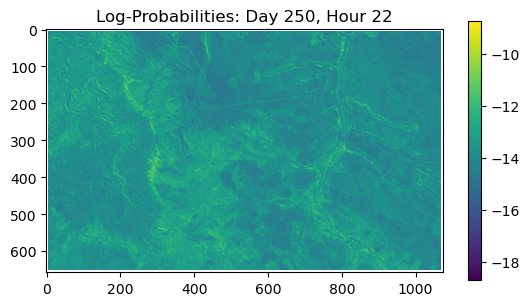

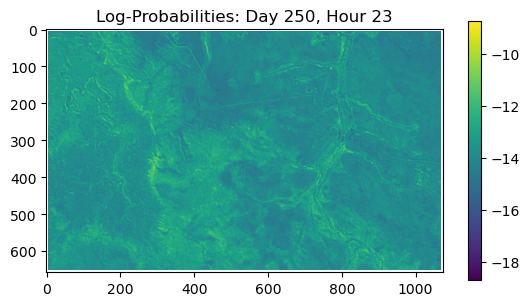

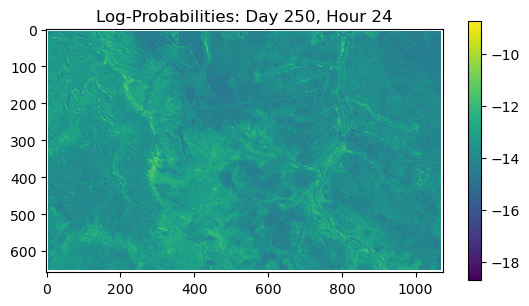

In [139]:
for hour_t2 in hours:

    # convert hour to sine and cosine
    hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
    hour_t2_cos = np.cos(2*np.pi*hour_t2/24)

    # Convert numpy objects to PyTorch tensors
    hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float().unsqueeze(0)
    hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float().unsqueeze(0)
    yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float().unsqueeze(0)
    yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float().unsqueeze(0)

    # Stack tensors column-wise to create a tensor of shape 
    scalar_covariates = torch.stack([hour_t2_sin_tensor, 
                                     hour_t2_cos_tensor, 
                                     yday_t2_sin_tensor, 
                                     yday_t2_cos_tensor], 
                                     dim=0)
    
    # Convert each scalar covariate into a grid matching the dimensions of the NDVI landscape
    scalar_grids = torch.cat([scalar_to_grid(tensor, 
                                             slope_subset.shape[0], 
                                             slope_subset.shape[1]) 
                                             for tensor in scalar_covariates
                                             ], dim=1)

    # Stack the spatial (landscape_stack) and scalar covariates (as grids)
    full_stack = torch.cat([landscape_stack, scalar_grids], dim=1)
    # print(full_stack.shape) # Expected shape: [1, n_channels, rows, cols]

    # Run the model
    landscape_predictions = model.conv_habitat(full_stack)
    # print(landscape_predictions.shape)

    # Pull out the prediction
    output_image = landscape_predictions[0].detach().cpu().numpy()

    # Mask out cells on the edges (that affect the colour scale)
    output_image = output_image * x_mask * y_mask

    # Habitat selection log-probabilities
    filename_landscape_preds = f"{base_id_day_dir}/id{buffalo_id}_log_hab_sel_yday{yday_t2}_hour{hour_t2}.png"
    plt.figure()  # Create a new figure
    plt.imshow(output_image, vmin=landscape_vmin, vmax=landscape_vmax)
    plt.colorbar(shrink=0.7)
    plt.title(f'Log-Probabilities: Day {yday_t2}, Hour {hour_t2}')
    plt.savefig(filename_landscape_preds, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory

    # # Habitat selection probabilities
    # filename_landscape_preds = f"{base_id_day_dir}/id{buffalo_id}_hab_sel_yday{yday_t2}_hour{hour_t2}.png"
    # plt.figure()  # Create a new figure
    # plt.imshow(np.exp(output_image), vmin=np.exp(landscape_vmin), vmax=np.exp(landscape_vmax))
    # plt.colorbar(shrink=0.7)
    # plt.title(f'Probabilities: Day {yday_t2}, Hour {hour_t2}')
    # plt.savefig(filename_landscape_preds, dpi=300, bbox_inches='tight')
    # plt.show()
    # plt.close()  # Close the figure to free memory
